In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

In [2]:
path = "F:/Document/France/ENPC/Cours/S5/Projet/data/"
os.chdir(path)
df_data = pd.read_csv("data done.csv", header=0)
np_data = df_data.values
np.random.shuffle(np_data)
np_vitesse = np_data[:, :614]
np_frf = np_data[:, 614:1228]
np_classe = np_data[:, 1228:]
vmax = np_vitesse.max()
vmin = np_vitesse.min()
fmax = np_frf.max()
fmin = np_frf.min()
np_vitesse = (np_vitesse - vmin) / (vmax - vmin)
np_frf = (np_frf - fmin) / (fmax - fmin)
ts_vitesse = torch.tensor(np_vitesse, dtype=torch.float32).reshape(np_vitesse.shape[0], 1, np_vitesse.shape[1])
ts_frf = torch.tensor(np_frf, dtype=torch.float32).reshape(np_frf.shape[0], 1, np_frf.shape[1])
ts_classe = torch.tensor(np_classe, dtype=torch.float32)
ts_feature = torch.concat((ts_vitesse, ts_frf), dim=1)

In [3]:
threshold1 = int(0.6*ts_feature.shape[0])
threshold2 = int(0.8*ts_feature.shape[0])
X_train_v = ts_vitesse[:threshold1]
X_train_f = ts_frf[:threshold1]
X_train = ts_feature[:threshold1]
Y_train = ts_classe[:threshold1]
X_valid_v = ts_vitesse[threshold1:threshold2]
X_valid_f = ts_frf[threshold1:threshold2]
X_valid = ts_feature[threshold1:threshold2]
Y_valid = ts_classe[threshold1:threshold2]
X_test_v = ts_vitesse[threshold2:]
X_test_f = ts_frf[threshold2:]
X_test = ts_feature[threshold2:]
Y_test = ts_classe[threshold2:]

In [4]:
def try_gpu(i=0):
    """if gpu exist, return gpu(i), otherwise, return cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

device = try_gpu()

In [5]:
np_label = Y_train.argmax(axis=1).numpy()
index_2 = np.where(np_label == 2)
index_3 = np.where(np_label == 3)
index_4 = np.where(np_label == 4)

In [6]:
X_v_2 = X_train_v[index_2]
X_v_3 = X_train_v[index_3]
X_v_4 = X_train_v[index_4]
X_frf_2 = X_train_f[index_2]
X_frf_3 = X_train_f[index_3]
X_frf_4 = X_train_f[index_4]
Y_2 = Y_train[index_2]
Y_3 = Y_train[index_3]
Y_4 = Y_train[index_4]

In [7]:
class VAE(nn.Module):
    def __init__(self, input_channel, h_dim=9216, z_dim=1024):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(input_channel, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (256, 36)),
            nn.ConvTranspose1d(256, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose1d(128, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose1d(64, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.ConvTranspose1d(32, input_channel, kernel_size=4, stride=2),
            nn.Sigmoid()
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size()).to(device)
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [8]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [9]:
VAEnet_v = VAE(input_channel=1)
VAEnet_f = VAE(input_channel=1)

In [10]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
num_epochs, lr, weight_decay, batch_size = 20, 1e-3, 0, 64

In [11]:
def train_vae(net, X_train, Y_train, num_epochs, lr, weight_decay, batch_size, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)
    net.apply(init_weights)
    print('training on', device)
    net.to(device)
    train_iter = d2l.load_array((X_train, Y_train), batch_size)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=lr,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        net.train()
        for i, (X, y) in enumerate(train_iter):
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            z, mu, logvar = net(X)
            l = loss_fn(z, X, mu, logvar)
            l.backward()
            optimizer.step()
        print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, 
                                num_epochs, l/batch_size))

In [12]:
train_vae(VAEnet_v, X_train_v, Y_train, num_epochs, lr, weight_decay, batch_size, device)

training on cuda:0
Epoch[1/20] Loss: 58.861
Epoch[2/20] Loss: 58.815
Epoch[3/20] Loss: 58.822
Epoch[4/20] Loss: 58.795
Epoch[5/20] Loss: 58.822
Epoch[6/20] Loss: 58.798
Epoch[7/20] Loss: 58.793
Epoch[8/20] Loss: 58.770
Epoch[9/20] Loss: 58.801
Epoch[10/20] Loss: 58.815
Epoch[11/20] Loss: 58.789
Epoch[12/20] Loss: 58.831
Epoch[13/20] Loss: 58.784
Epoch[14/20] Loss: 58.810
Epoch[15/20] Loss: 58.765
Epoch[16/20] Loss: 58.824
Epoch[17/20] Loss: 58.770
Epoch[18/20] Loss: 58.795
Epoch[19/20] Loss: 58.807
Epoch[20/20] Loss: 58.813


In [13]:
train_vae(VAEnet_f, X_train_f, Y_train, num_epochs, lr, weight_decay, batch_size, device)

training on cuda:0
Epoch[1/20] Loss: 7.815
Epoch[2/20] Loss: 3.144
Epoch[3/20] Loss: 9.608
Epoch[4/20] Loss: 8.508
Epoch[5/20] Loss: 0.860
Epoch[6/20] Loss: 0.917
Epoch[7/20] Loss: 0.930
Epoch[8/20] Loss: 0.979
Epoch[9/20] Loss: 0.934
Epoch[10/20] Loss: 0.868
Epoch[11/20] Loss: 0.927
Epoch[12/20] Loss: 1.028
Epoch[13/20] Loss: 0.799
Epoch[14/20] Loss: 1.271
Epoch[15/20] Loss: 0.802
Epoch[16/20] Loss: 0.863
Epoch[17/20] Loss: 1.018
Epoch[18/20] Loss: 0.717
Epoch[19/20] Loss: 0.944
Epoch[20/20] Loss: 0.864


In [38]:
torch.save(VAEnet_v, "./VAEnet_v.pkl")
torch.save(VAEnet_f, "./VAEnet_f.pkl")

In [14]:
def compare_signal(signal, recon_signal):
    fig, axs = plt.subplots(2, figsize=(12,12))
    axs[0].plot(signal[0])
    axs[1].plot(recon_signal[0])
    plt.show()

In [15]:
# recon_v = VAEnet_v(X_v_2.to(device))
# signal = X_v_2.detach().numpy()
# recon_signal = recon_v[0].cpu()
# recon_signal = recon_signal.detach().numpy()

In [16]:
class_train = Y_train.argmax(axis=1).numpy()
np.unique(class_train, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([4765, 6187, 1259,  128,   22], dtype=int64))

In [26]:
def data_augmentation(X, Y, VAEnet):
    times = 3000 // len(X) + 1
    X_new = X
    Y_new = Y
    for i in range(times):
        recon = VAEnet(X)
        X_recon = recon[0]
        Y_recon = Y
        X_new = torch.concat((X_new, X_recon), dim=0)
        Y_new = torch.concat((Y_new, Y_recon), dim=0)
    return X_new, Y_new

In [40]:
VAEnet_f.cpu()
VAEnet_v.cpu()
device = 'cpu'

In [28]:
X_frf_2_new, Y_2_new = data_augmentation(X_frf_2, Y_2, VAEnet_f)
X_frf_3_new, Y_3_new = data_augmentation(X_frf_3, Y_3, VAEnet_f)
X_frf_4_new, Y_4_new = data_augmentation(X_frf_4, Y_4, VAEnet_f)

In [47]:
X_frf_2_new = X_frf_2_new * (fmax - fmin) + fmin
X_frf_3_new = X_frf_3_new * (fmax - fmin) + fmin
X_frf_4_new = X_frf_4_new * (fmax - fmin) + fmin

In [48]:
X_train_f_new = torch.concat((X_train_f, X_frf_2_new, X_frf_3_new, X_frf_4_new), dim=0)
Y_train_new = torch.concat((Y_train, Y_2_new, Y_3_new, Y_4_new), dim=0)
index_new = np.arange(len(X_train_f_new))
np.random.shuffle(index_new)
X_train_f_new = X_train_f_new[index_new]
Y_train_new = Y_train_new[index_new]

In [63]:
X_v_2_new, Y_2_new = data_augmentation(X_v_2, Y_2, VAEnet_v)
X_v_3_new, Y_3_new = data_augmentation(X_v_3, Y_3, VAEnet_v)
X_v_4_new, Y_4_new = data_augmentation(X_v_4, Y_4, VAEnet_v)

In [64]:
X_v_2_new = X_v_2_new * (vmax - vmin) + vmin
X_v_3_new = X_v_3_new * (vmax - vmin) + vmin
X_v_4_new = X_v_4_new * (vmax - vmin) + vmin

In [65]:
X_train_v_new = torch.concat((X_train_v, X_v_2_new, X_v_3_new, X_v_4_new), dim=0)
Y_train_new = torch.concat((Y_train, Y_2_new, Y_3_new, Y_4_new), dim=0)
X_train_f_new = X_train_f_new[index_new]
Y_train_new = Y_train_new[index_new]

In [52]:
torch.save(X_train_f_new, 'X_train_f_new.pt')
torch.save(Y_train_new, 'Y_train_f_new.pt')

In [66]:
torch.save(X_train_v_new, 'X_train_v_new.pt')
torch.save(Y_train_new, 'Y_train_v_new.pt')

In [54]:
torch.save(X_valid_f, 'X_valid_f.pt')
torch.save(Y_valid, 'Y_valid.pt')
torch.save(X_test_f, 'X_test_f.pt')
torch.save(Y_test, 'Y_test.pt')

In [ ]:
torch.save(X_valid_v, 'X_valid_v.pt')
torch.save(X_test_v, 'X_test_v.pt')

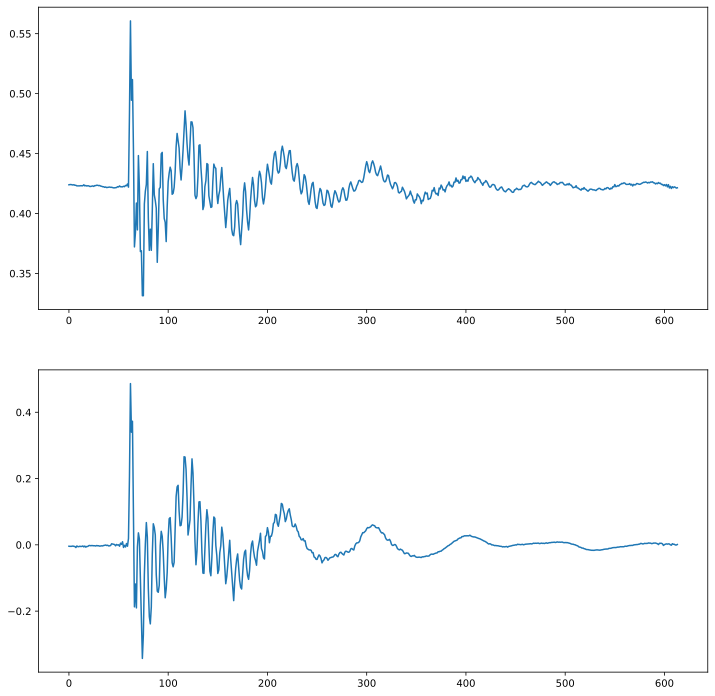

In [67]:
compare_signal(X_v_2[0], X_v_2_new[1259].detach().numpy())